##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
# %pip install pandas 
# %pip install matplotlib
#add commented pip installation lines for packages used as shown above for ease of testing
#the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [2]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catA_train.csv" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv(filepath)
#print(df.info())
#df.isna().sum()

# cleaning of data
df = df.dropna(subset=["LATITUDE","LONGITUDE"])

df = df[df['Company Status (Active/Inactive)'] == 'Active']

# to ensure important info isnt being lost
df['Import/Export Status_Missing'] = df['Import/Export Status'].isna() # whether the company imports or exports make a difference in their sales
df1 = df.dropna(subset=["Employees (Single Site)", 'Employees (Domestic Ultimate Total)', 'Employees (Global Ultimate Total)', 'Year Found'])

df2 = pd.get_dummies(df1, columns=['Entity Type'], prefix='Entity_Type')
df2 = pd.get_dummies(df1, columns=['Ownership Type'], prefix='Ownership_Type')
df2 = pd.get_dummies(df1, columns=['Import/Export Status'], prefix='Import_Export_Status')
df2 = df1.drop(columns=[col for col in ["Company Status (Active/Inactive)", "Entity Type", "Import/Export Status", "Ownership Type"] if col in df1.columns], errors='ignore')

df2.isna().sum()

# remove companies with low frequency of SIC code
# Find the frequency of each industry
sic_code_frequency = df2['SIC Code'].value_counts()

# Set a threshold for low-frequency SIC Codes
threshold = 10 # adjust the threshold based on your preferences decrease to 185

# Identify SIC Codes with frequency below the threshold 
low_frequency_sic_codes = sic_code_frequency[sic_code_frequency < threshold].index

# Replace these low-frequency SIC Codes with a common label] "others"
df2['SIC Code'] = df2['SIC Code'].replace(low_frequency_sic_codes,'Others')
sic_code_frequency1 = df2['SIC Code'].value_counts()

# Display the updated Dataframe:
#print(sic_code_frequency1)

df2['SIC Code'] = df2['SIC Code'].astype(str)
# use label encoidng for 'SIC Code'ArithmeticError
label_encoder = LabelEncoder()
df2['SIC Code'] = label_encoder.fit_transform(df2['SIC Code'])
df2['SIC Code'].unique()

# remove square footage column due to the high number of NA values
df2 = df2.drop('Square Footage',axis=1)
#print(df2)
#df2.describe()
df2.columns

Index(['LATITUDE', 'LONGITUDE', 'AccountID', 'Company', 'SIC Code', 'Industry',
       '8-Digit SIC Code', '8-Digit SIC Description', 'Year Found',
       'Parent Company', 'Parent Country', 'Company Description',
       'Employees (Single Site)', 'Employees (Domestic Ultimate Total)',
       'Employees (Global Ultimate Total)',
       'Sales (Domestic Ultimate Total USD)',
       'Sales (Global Ultimate Total USD)', 'Fiscal Year End',
       'Global Ultimate Company', 'Global Ultimate Country',
       'Domestic Ultimate Company', 'Is Domestic Ultimate',
       'Is Global Ultimate', 'Import/Export Status_Missing'],
      dtype='object')

In [58]:
# Data Manipulation
from sklearn.feature_selection import VarianceThreshold
threshold_value = 0.5
std_dev = df2.std()
high_std_col = std_dev[std_dev>threshold_value].index
df_high_std = df2[high_std_col]
print(df_high_std)

       SIC Code  8-Digit SIC Code  Year Found  Employees (Single Site)  \
1            44        44490000.0      2015.0                     39.0   
2           129        67190000.0      1993.0                      4.0   
3           129        67190000.0      2006.0                     10.0   
5           184        49590000.0      1986.0                    300.0   
7           129        67190000.0      2010.0                     10.0   
...         ...               ...         ...                      ...   
29171       129        67190000.0      2020.0                     10.0   
29175       155        73890000.0      2009.0                     25.0   
29176         9        17310000.0      1996.0                    100.0   
29180       129        67190000.0      2018.0                     10.0   
29181        83        50990000.0      2018.0                     11.0   

       Employees (Domestic Ultimate Total)  Employees (Global Ultimate Total)  \
1                             

In [63]:
#df2['Is Domestic Ultimate'] = df2['Is Domestic Ultimate'] == 1
#df2['Is Global Ultimate'] = df2['Is Global Ultimate'] == 1
#df2.columns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
# Separate features and target variable
df3 =df2.select_dtypes(include=['number'])
df3.columns

Index(['LATITUDE', 'LONGITUDE', 'SIC Code', '8-Digit SIC Code', 'Year Found',
       'Employees (Single Site)', 'Employees (Domestic Ultimate Total)',
       'Employees (Global Ultimate Total)',
       'Sales (Domestic Ultimate Total USD)',
       'Sales (Global Ultimate Total USD)', 'Is Domestic Ultimate',
       'Is Global Ultimate'],
      dtype='object')

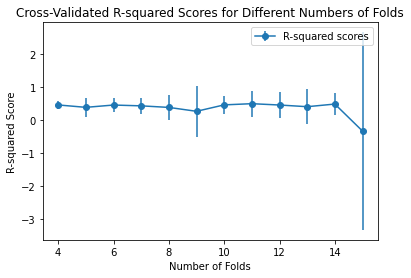

In [64]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import numpy as np
# Separate features and target variable

X = df3.drop('Sales (Domestic Ultimate Total USD)', axis=1)
y = df3['Sales (Domestic Ultimate Total USD)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=42)

n_folds_values = list(range(4, 16))
mean_r2_scores = []
std_r2_scores = []

# Iterate over different numbers of folds
for n_folds in n_folds_values:
    # Use k-fold cross-validation with the current number of folds
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Perform cross-validation and get R-squared scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

    # Append mean and standard deviation of R-squared scores to lists
    mean_r2_scores.append(cv_scores.mean())
    std_r2_scores.append(cv_scores.std())

# Plot the results
plt.errorbar(n_folds_values, mean_r2_scores, yerr=std_r2_scores, marker='o', linestyle='-', label='R-squared scores')
plt.xlabel('Number of Folds')
plt.ylabel('R-squared Score')
plt.title('Cross-Validated R-squared Scores for Different Numbers of Folds')

plt.legend()
plt.show()

In [65]:
print(mean_r2_scores)

[0.46052517817492455, 0.3878155467933905, 0.45759915776239346, 0.43298222389026214, 0.38593032381975245, 0.26825797953016406, 0.4625527498071723, 0.4985068013262404, 0.458114907599584, 0.40746766413751584, 0.4873331247232954, -0.32944695222200904]


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [4]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''

    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [5]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

[]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!